In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [5]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * 1e9
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * 1e9
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * 1e9
    return df

In [6]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [7]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))
    #fig, axes = plt.subplots(nrows=2, ncols=2)

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot)
        axes[indx].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)', fontsize=fontsize_axis, rot=rot)
    #axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)', fontsize=fontsize_axis, rot=rot)
    #axes[0][1].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis, rot=rot)
    #axes[1][0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Memory per Rank'].plot(kind='bar', ax = axes[1][1], title='Memory per Rank', fontsize=fontsize_axis, rot=rot)
    #axes[1][1].legend(fontsize=fontsize_legends, loc=legend_loc)
        
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    # y-axis labels
    if 'Conn. Creation Time per Conn. (min)' in values:  
        axes[0].set_ylabel('Time [ns]')  # Not safe..
    else:
        axes[0].set_ylabel('Time [s]')
        #axes[0][0].set_ylabel('Time [s]')
        #axes[1][0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')
        #axes[1][1].set_ylabel('Memory [GiB]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [8]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,55.93,47.75,110.79,2.743245,0.022790,0.056008
72,56.16,50.03,113.02,2.743245,0.025231,0.053362
144,56.73,47.69,111.17,2.743245,0.108890,0.053382
288,55.07,52.39,119.53,2.743245,0.113862,0.053393
576,53.97,59.77,126.65,2.743245,0.238075,0.053747
1152,53.90,83.27,150.91,2.743083,0.583995,0.055154


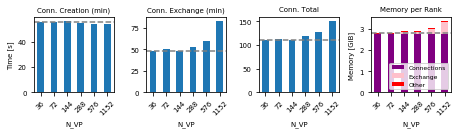

In [32]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC static

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,50.38,44.34,106.29,1.930745,0.082848,0.057636
72,50.39,47.27,108.31,1.930745,0.140628,0.055966
144,50.61,46.64,110.56,1.930745,0.138309,0.053382
288,48.95,49.19,110.87,1.951579,0.350760,0.053393
576,49.90,59.29,121.61,1.993245,0.419607,0.053747
1152,49.24,81.91,144.39,1.993083,0.452431,0.054612


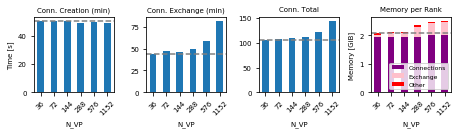

In [10]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_table.txt')
hpc_static_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,59.03,55.15,123.98,2.743245,0.022139,0.051125
72,59.38,62.68,130.93,2.743245,0.036027,0.053362
144,59.12,56.11,126.83,2.743245,0.113203,0.053382
288,57.37,59.52,130.55,2.743245,0.170184,0.053393
576,57.13,66.91,139.17,2.743245,0.520410,0.053747
1152,56.60,91.91,165.08,2.743083,0.604612,0.054612


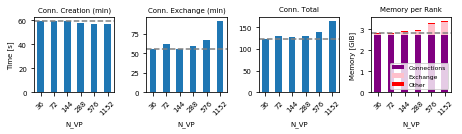

In [11]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_random_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_random_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_random_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,52.94,48.75,108.34,1.930745,0.395348,0.051125
72,53.27,48.90,109.68,1.930745,0.394128,0.053362
144,54.14,52.98,117.80,1.930745,0.403486,0.053382
288,52.39,53.71,117.39,1.951579,0.457815,0.053393
576,52.51,62.07,127.60,1.993245,0.417980,0.053747
1152,52.16,91.93,156.84,1.993083,0.452973,0.054612


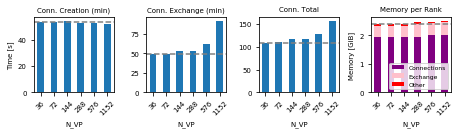

In [13]:
hpc_static_del_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static_random_delays.csv')

hpc_static_del_t6_s20 = calculate_T_conn_and_memory(hpc_static_del_t6_s20)
hpc_static_del_t6_s20_p = plot_results(hpc_static_del_t6_s20,
                                       'benchmark_figures/hpc_benchmark_static_random_delays.pdf')

save_table_latex(hpc_static_del_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_random_delays_table.txt')
hpc_static_del_t6_s20_p

## HPC Split into many `Connect` calls

Constant number of Connect calls

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,95.41,45.56,155.79,2.743245,0.018721,0.060565
72,97.38,44.53,155.91,2.743245,0.026886,0.091123
144,100.26,45.61,159.91,2.743245,0.103275,0.228349
288,104.90,48.86,169.51,2.743245,0.105317,0.458070
576,115.24,56.96,189.66,2.743245,0.182954,0.420111
1152,136.34,78.57,234.10,2.743083,0.545475,0.271888


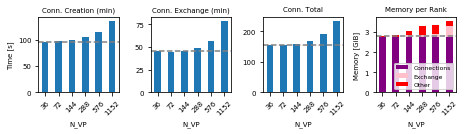

In [14]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_constant_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20,
                                  'benchmark_figures/hpc_benchmark_constant_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_constant_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,96.22,44.47,153.41,2.743245,0.017093,0.060077
72,229.32,44.13,305.57,2.743245,0.026072,0.112227
144,731.69,45.62,848.92,2.826579,0.018721,0.209293
288,2634.76,44.50,2937.91,2.933350,0.117605,0.332148
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


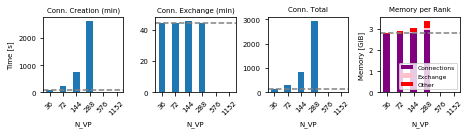

In [15]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_increased_split.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_increased_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_increased_split_table.txt')
hpc_split_increase_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                                               \
Case              Default Random delay Random delay and static   Split   
N_VP                                                                     
36                  55.93        59.03                   52.94   95.41   
72                  56.16        59.38                   53.27   97.38   
144                 56.73        59.12                   54.14  100.26   
288                 55.07        57.37                   52.39  104.90   
576                 53.97        57.13                   52.51  115.24   
1152                53.90        56.60                   52.16  136.34   

                    Conn. Exchange (min)                                       \
Case Static synapse              Default Random delay Random delay and static   
N_VP                                                                            
36            50.38                47.75        55.15                   48.75   
72            50.39                50.03        62.68                   48.90   
144           50.61                47.69        56.11                   52.98   
288           48.95                52.39        59.52                   53.71   
576           49.90                59.77        66.91                   62.07   
1152          49.24                83.27        91.91                   91.93   

                           Conn. Total                                       \
Case  Split Static synapse     Default Random delay Random delay and static   
N_VP                                                                          
36    45.56          44.34      110.79       123.98                  108.34   
72    44.53          47.27      113.02       130.93                  109.68   
144   45.61          46.64      111.17       126.83                  117.80   
288   48.86          49.19      119.53       130.55                  117.39   
576   56.96          59.29      126.65       139.17                  127.60   
1152  78.57          81.91      150.91       165.08                  156.84   

                            Memory per Rank               \
Case   Split Static synapse         Default Random delay   
N_VP                                                       
36    155.79         106.29        2.822043     2.816509   
72    155.91         108.31        2.821839     2.832635   
144   159.91         110.56        2.905517     2.909830   
288   169.51         110.87        2.910500     2.966822   
576   189.66         121.61        3.035068     3.317403   
1152  234.10         144.39        3.382232     3.402306   

                                                       
Case Random delay and static     Split Static synapse  
N_VP                                                   
36                  2.377219  2.822531       2.071229  
72                  2.378235  2.861254       2.127340  
144                 2.387614  3.074869       2.122436  
288                 2.462787  3.306632       2.355732  
576                 2.464972  3.346310       2.466600  
1152                2.500667  3.560446       2.500125

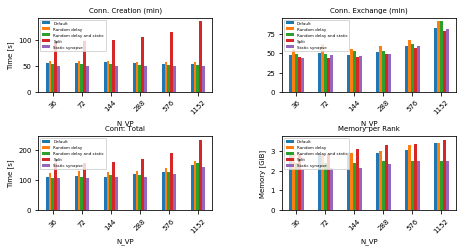

In [73]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_static_t6_s20['Case'] = ['Static synapse'] * len(hpc_static_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_static_del_t6_s20['Case'] = ['Random delay and static'] * len(hpc_static_del_t6_s20)
hpc_split_t6_s20['Case'] = ['Split'] * len(hpc_split_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_static_t6_s20, hpc_delay_t6_s20, hpc_static_del_t6_s20, hpc_split_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf', legend_loc='upper left')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0     2498000500
1     4996000000
2     9991999000
3    19983997000
4    39967993000
5    79935985000
Name: N_conns_sum, dtype: int64
0      499500
1      999000
2     1998000
3     3996000
4     7992000
5    15984000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,54.76,47.87,108.53,2.720052,0.048310,0.070738
72,53.54,49.59,111.41,2.720052,0.317140,0.073137
144,55.32,54.00,116.85,2.720052,0.172220,0.073157
288,53.19,63.51,127.21,2.720052,0.320106,0.073169
576,52.76,87.74,154.82,2.720052,0.661527,0.073523
1152,52.40,154.87,220.98,2.720052,0.780393,0.074224


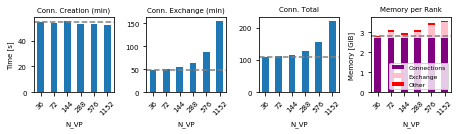

In [17]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comparison_benchmark_8adec3cd_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons_population_comparison.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_populations_comp_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,45.75,39.25,93.81,1.979818,0.105624,0.065204
72,46.64,40.00,95.79,1.975260,0.123853,0.071347
144,47.91,40.45,98.53,1.975260,0.215827,0.071367
288,50.44,43.82,103.67,1.975260,0.116873,0.071378
576,54.71,54.46,118.66,1.975260,0.398448,0.071732
1152,66.78,95.90,176.92,1.975260,0.454258,0.072434


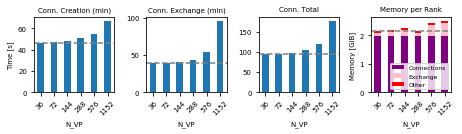

In [18]:
population = pd.read_csv('benchmark_results/population_model_8adec3cd_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## HPC benchmark vs HPC benchmark with many synapses per neuron

Conn. Creation (min)               Conn. Exchange (min)                \
Case              Default many synapses              Default many synapses   
N_VP                                                                         
36                  55.93         54.76                47.75         47.87   
72                  56.16         53.54                50.03         49.59   
144                 56.73         55.32                47.69         54.00   
288                 55.07         53.19                52.39         63.51   
576                 53.97         52.76                59.77         87.74   
1152                53.90         52.40                83.27        154.87   

     Conn. Total               Memory per Rank                
Case     Default many synapses         Default many synapses  
N_VP                                                          
36        110.79        108.53        2.822043      2.839100  
72        113.02        111.41        2.821839      3.110330  
144       111.17        116.85        2.905517      2.965430  
288       119.53        127.21        2.910500      3.113327  
576       126.65        154.82        3.035068      3.455101  
1152      150.91        220.98        3.382232      3.574669

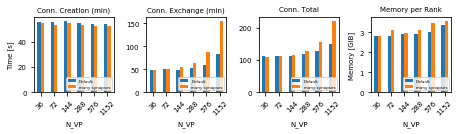

In [19]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_pop_comp['Case'] = ['many synapses'] * len(hpc_pop_comp)

hpc_cases = pd.concat([hpc_t6_s20, hpc_pop_comp])

hpc_synapse_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases.pdf')
save_table_latex(hpc_synapse_cases_p.to_latex(), 'latex_tables/hpc_synapse_cases_table.txt')

hpc_synapse_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             22.093830     21.921533   
72                             11.092345     10.716573   
144                             5.602464      5.536430   
288                             2.719264      2.661630   
576                             1.332474      1.320056   
1152                            0.665373      0.655525   

     Conn. Exchange Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             18.862513     19.163327   
72                              9.881589      9.925941   
144                             4.709704      5.404324   
288                             2.586930      3.178043   
576                             1.475671      2.195257   
1152                            1.027933      1.937425   

     Total Conn. Time per Conn.                
Case                    Default many synapses  
N_VP                                           
36                    43.764981     43.446749  
72                    22.322950     22.299840  
144                   10.978776     11.694357  
288                    5.902191      6.365593  
576                    3.126882      3.873600  
1152                   1.862921      2.764462

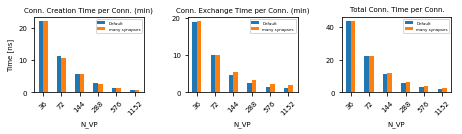

In [20]:
hpc_cases = time_per_connection(hpc_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_cases_tpc__p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases_time_per_conn.pdf',
                                        values, legend_loc='upper right')
save_table_latex(hpc_synapse_cases_tpc__p.to_latex(), 'latex_tables/hpc_synapse_cases_time_per_conn_table.txt')

hpc_synapse_cases_tpc__p

## HPC benchmark with many synapses per neuron vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case        many synapses population        many synapses population   
N_VP                                                                   
36                  54.76      45.75                47.87      39.25   
72                  53.54      46.64                49.59      40.00   
144                 55.32      47.91                54.00      40.45   
288                 53.19      50.44                63.51      43.82   
576                 52.76      54.71                87.74      54.46   
1152                52.40      66.78               154.87      95.90   

       Conn. Total            Memory per Rank             
Case many synapses population   many synapses population  
N_VP                                                      
36          108.53      93.81        2.839100   2.150646  
72          111.41      95.79        3.110330   2.170461  
144         116.85      98.53        2.965430   2.262454  
288         127.21     103.67        3.113327   2.163512  
576         154.82     118.66        3.455101   2.445441  
1152        220.98     176.92        3.574669   2.501953

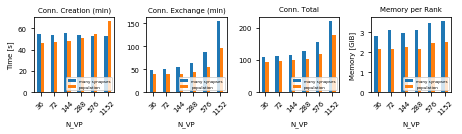

In [21]:
population['Case'] = ['population'] * len(population)

hpc_synapse_pop_cases = pd.concat([hpc_pop_comp, population])

hpc_synapse_pop_cases_p = plot_compare(hpc_synapse_pop_cases, 'benchmark_figures/hpc_synapse_vs_pop_cases.pdf')
save_table_latex(hpc_synapse_pop_cases_p.to_latex(), 'latex_tables/hpc_synapse_vs_pop_cases_table.txt')

hpc_synapse_pop_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             21.921533   18.30000   
72                             10.716573    9.32800   
144                             5.536430    4.79100   
288                             2.661630    2.52200   
576                             1.320056    1.36775   
1152                            0.655525    0.83475   

     Conn. Exchange Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             19.163327   15.70000   
72                              9.925941    8.00000   
144                             5.404324    4.04500   
288                             3.178043    2.19100   
576                             2.195257    1.36150   
1152                            1.937425    1.19875   

     Total Conn. Time per Conn.             
Case              many synapses population  
N_VP                                        
36                    43.446749    37.5240  
72                    22.299840    19.1580  
144                   11.694357     9.8530  
288                    6.365593     5.1835  
576                    3.873600     2.9665  
1152                   2.764462     2.2115

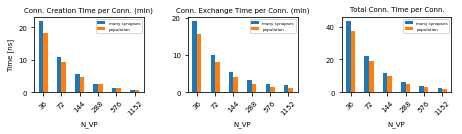

In [22]:
hpc_synapse_pop_cases = time_per_connection(hpc_synapse_pop_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_pop_tpc_cases_p = plot_compare(hpc_synapse_pop_cases,
                                           'benchmark_figures/hpc_synapse_vs_pop_cases_time_per_conn.pdf',
                                           values, legend_loc='upper right')
save_table_latex(hpc_synapse_pop_tpc_cases_p.to_latex(),
                 'latex_tables/hpc_synapse_vs_pop_cases_time_per_conn_table.txt')

hpc_synapse_pop_tpc_cases_p

## Compare nblocks and population

Conn. Creation Time per Conn. (min)             \
Case                             NBLOCKS population   
N_VP                                                  
36                             37.854336   18.30000   
72                             19.317975    9.32800   
144                             9.944652    4.79100   
288                             5.202444    2.52200   
576                             2.857625    1.36775   
1152                            1.690422    0.83475   

     Conn. Exchange Time per Conn. (min)             \
Case                             NBLOCKS population   
N_VP                                                  
36                             18.076130   15.70000   
72                              8.833738    8.00000   
144                             4.523993    4.04500   
288                             2.423178    2.19100   
576                             1.412446    1.36150   
1152                            0.974156    1.19875   

     Total Conn. Time per Conn.             
Case                    NBLOCKS population  
N_VP                                        
36                    61.810366    37.5240  
72                    30.928995    19.1580  
144                   15.861253     9.8530  
288                    8.406733     5.1835  
576                    4.703029     2.9665  
1152                   2.902507     2.2115

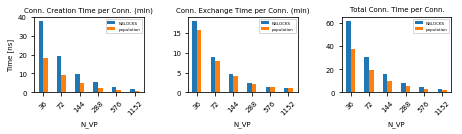

In [77]:
hpc_split_t6_s20['Case']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['Case'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['Case']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

increasing_conns_p = plot_compare(increasing_conns, 'benchmark_figures/nblocks_vs_population.pdf',
                                  values=values, legend_loc='upper right')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/nblocks_vs_population.txt')

increasing_conns_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 5 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             11.849371      13.714062       68.034521   
72                              5.964855       6.537685       61.721420   
144                             3.051710       3.416979       46.159642   
288                             1.523422       1.679850       43.552703   
576                             0.746905       0.852764       40.714475   
1152                            0.370214       0.431813       40.543100   

                                            \
Case fixed total number pairwise bernoulli   
N_VP                                         
36         11208.791209          15.501512   
72         19889.502762           7.877001   
144        37700.831025           4.886515   
288        74916.782247           3.327117   
576       151040.943789           2.668853   
1152      302957.306491           2.317085   

     Conn. Exchange Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                              9.321505      10.285546        8.202249   
72                              5.056301       5.028685       14.964881   
144                             2.745552       2.435338        8.125828   
288                             1.182689       1.288774        4.218315   
576                             0.575302       0.691790        2.334633   
1152                            0.264350       0.389595        1.360296   

                                           Total Conn. Time per Conn.  \
Case fixed total number pairwise bernoulli                 all to all   
N_VP                                                                    
36           274.725275           9.939298                  21.170876   
72           303.867403           4.558706                  11.060658   
144          193.905817           2.324749                   5.797262   
288          131.761442           1.301615                   2.706111   
576          117.973629           0.679434                   1.322825   
1152          50.329747           0.369104                   0.634719   

                                                                           
Case fixed indegree fixed outdegree fixed total number pairwise bernoulli  
N_VP                                                                       
36        23.999608       76.236771       11483.516484          25.440810  
72        11.570320       76.689206       20220.994475          12.435707  
144        5.854292       54.286923       37894.736842           7.213239  
288        2.969612       47.771744       75055.478502           4.629720  
576        1.545048       43.049471      151162.387231           3.348287  
1152       0.821655       41.903578      303009.371746           2.686436

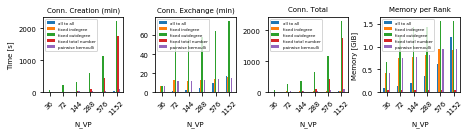

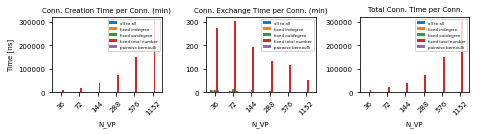

In [24]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_in.csv')
hpc_in['Case'] = ['fixed indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_out.csv')
hpc_out['Case'] = ['fixed outdegree']*len(hpc_out)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_all.csv')
hpc_all['Case'] = ['all to all']*len(hpc_all)

hpc_tot = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot.csv')
hpc_tot['Case'] = ['fixed total number']*len(hpc_tot)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_bern.csv')
hpc_bern['Case'] = ['pairwise bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_out])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')
hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper right')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

**Not including `fixed total number`:**

Conn. Creation Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             11.849371      13.714062       68.034521   
72                              5.964855       6.537685       61.721420   
144                             3.051710       3.416979       46.159642   
288                             1.523422       1.679850       43.552703   
576                             0.746905       0.852764       40.714475   
1152                            0.370214       0.431813       40.543100   

                        Conn. Exchange Time per Conn. (min)                 \
Case pairwise bernoulli                          all to all fixed indegree   
N_VP                                                                         
36            15.501512                            9.321505      10.285546   
72             7.877001                            5.056301       5.028685   
144            4.886515                            2.745552       2.435338   
288            3.327117                            1.182689       1.288774   
576            2.668853                            0.575302       0.691790   
1152           2.317085                            0.264350       0.389595   

                                        Total Conn. Time per Conn.  \
Case fixed outdegree pairwise bernoulli                 all to all   
N_VP                                                                 
36          8.202249           9.939298                  21.170876   
72         14.964881           4.558706                  11.060658   
144         8.125828           2.324749                   5.797262   
288         4.218315           1.301615                   2.706111   
576         2.334633           0.679434                   1.322825   
1152        1.360296           0.369104                   0.634719   

                                                        
Case fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                    
36        23.999608       76.236771          25.440810  
72        11.570320       76.689206          12.435707  
144        5.854292       54.286923           7.213239  
288        2.969612       47.771744           4.629720  
576        1.545048       43.049471           3.348287  
1152       0.821655       41.903578           2.686436

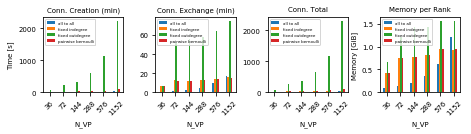

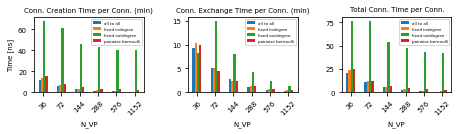

In [25]:
hpc_rules_no_tot = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out])

hpc_rules_no_tot = calculate_T_conn_and_memory(hpc_rules_no_tot)
hpc_rules_no_tot = time_per_connection(hpc_rules_no_tot)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_no_tot.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_table.txt')
hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_not_tot_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_time_per_connection_table.txt')

hpc_rules_no_tot_p

## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,120.426247,36.050572,156.477170,2.551239,0.071292,1.526557e-16
72,157.620768,36.592974,194.214109,2.552825,0.061337,3.987630e-03
144,244.647294,39.647938,284.296193,2.553713,0.173153,7.202148e-03
288,409.156298,43.565511,452.722374,2.626425,0.255225,1.665335e-16
576,730.886775,35.718095,766.605952,2.677611,0.105154,-5.551115e-17
1152,1437.297899,62.590330,1499.890033,2.940089,0.448385,-5.551115e-17


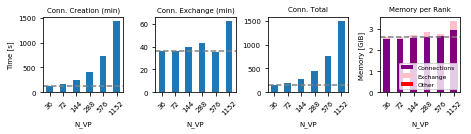

In [26]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_8adec3cd_daint_t6.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=False)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')

MAM_t6_s0_0625_p

## 4x4 mesocircuit

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,171.05,6.04,177.09,0.500407,0.118544,0.051779
72,194.96,6.58,201.55,0.519694,0.103678,0.066061
144,227.96,8.07,236.04,0.538167,0.124051,0.077799
288,333.89,8.96,342.87,0.453717,0.176499,0.105154
576,521.29,10.29,531.64,0.407574,0.230692,0.173216
1152,964.58,13.71,978.42,0.408856,0.366698,0.305754


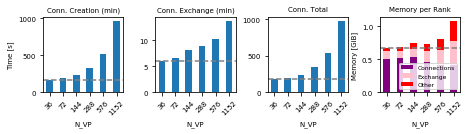

In [28]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_8adec4cd_daint_t6.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')

meso_t6_s0_0625_p

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                            495.160823  79.836050  22.093830   18.30000   
72                            282.171375  52.246920  11.092345    9.32800   
144                           164.953748  40.546873   5.602464    4.79100   
288                           120.802248  33.905959   2.719264    2.52200   
576                            94.301832  30.283553   1.332474    1.36775   
1152                           87.245928  29.776488   0.665373    0.83475   

     Conn. Exchange Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                             17.484779  23.899568  18.862513   15.70000   
72                              9.523429  12.129558   9.881589    8.00000   
144                             5.839519   6.571092   4.709704    4.04500   
288                             3.241751   3.610186   2.586930    2.19100   
576                             1.861470   1.479943   1.475671    1.36150   
1152                            1.240065   1.296683   1.027933    1.19875   

     Total Conn. Time per Conn.                                    
Case                        4x4         MAM        hpc population  
N_VP                                                               
36                   512.645601  103.735850  43.764981    37.5240  
72                   291.709277   64.376599  22.322950    19.1580  
144                  170.800503   47.118124  10.978776     9.8530  
288                  124.051234   37.516192   5.902191     5.1835  
576                   96.174156   31.763540   3.126882     2.9665  
1152                  88.497751   31.073209   1.862921     2.2115

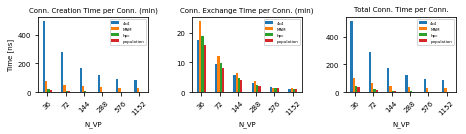

In [29]:
hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper right')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,17.40,11.70,29.40,1.915039,0.795025,0.386829
3,31.06,24.88,59.71,1.930013,0.293794,0.089876
6,41.26,34.54,81.53,1.995850,0.075687,0.047707
9,43.63,45.66,89.95,1.974826,0.076844,0.038896
18,57.58,71.10,130.47,1.953695,0.014393,0.040708
36,73.43,77.09,150.52,1.943454,0.020833,0.035204


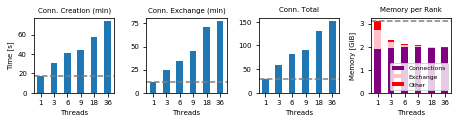

In [30]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                         Conn. Exchange (min)  \
Case                    2.14    2.16   2.18 8adec3cd                 2.14   
Threads                                                                     
1                      36.44   21.73  17.62    17.40                 0.62   
3                      47.89   38.73  30.85    31.06                 0.89   
6                      52.17   51.38  42.25    41.26                 0.96   
9                      53.47   58.84  43.85    43.63                 0.91   
18                     54.55   81.97  56.37    57.58                 1.38   
36                     61.78  124.92  74.22    73.43                 1.44   

                               Conn. Total                           \
Case      2.16   2.18 8adec3cd        2.14    2.16    2.18 8adec3cd   
Threads                                                               
1        18.79  11.87    11.70       38.13   41.59   29.74    29.40   
3        29.74  24.27    24.88       53.94   74.21   61.06    59.71   
6        35.99  32.64    34.54       55.97   89.20   78.62    81.53   
9        50.30  48.41    45.66       56.75  110.85   93.32    89.95   
18       66.25  68.98    71.10       58.47  151.96  127.35   130.47   
36       91.19  77.44    77.09       63.22  216.11  151.66   150.52   

        Memory per Rank                                
Case               2.14      2.16      2.18  8adec3cd  
Threads                                                
1              2.312773  5.072531  3.096897  3.096893  
3              2.028328  4.422857  2.269574  2.313683  
6              1.983972  4.332034  2.121685  2.119244  
9              1.973401  4.311907  2.100494  2.090566  
18             1.963256  4.293865  2.008091  2.008796  
36             1.968212  4.284930  1.989075  1.999492

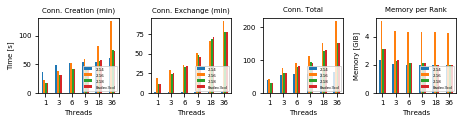

In [31]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_threads_218['Case'] = ['2.18']*len(hpc_threads_218)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')
hpc_threads_m['Case']   = ['8adec3cd']*len(hpc_threads_m)
# hpc_threads_5g  = pd.read_csv('benchmark_results/hpc_benchmark_5g_daint_threads.csv')
# hpc_threads_5g['Case']  = ['5g']*len(hpc_threads_5g)
# hpc_threads_3   = pd.read_csv('benchmark_results/hpc_benchmark_3_daint_threads.csv')
# hpc_threads_3['version']   = ['3']*len(hpc_threaDs_3)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_218, hpc_threads_m])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0)
save_table_latex(hpc_threads_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p

Conn. Creation (min)                        Conn. Exchange (min)  \
Case                       2.14   2.16   2.18 8adec3cd                 2.14   
num. nodes                                                                    
1                         35.65  21.84  17.56    17.43                 0.60   
2                         37.68  21.74  17.36    17.29                 0.63   
4                         39.38  21.71  17.38    17.32                 0.58   
8                         40.99  22.01  17.39    17.30                 0.67   
16                        42.90  21.77  17.39    17.38                 0.90   
32                        43.87  21.73  17.37    17.39                 1.28   

                                  Conn. Total                         \
Case         2.16   2.18 8adec3cd        2.14   2.16   2.18 8adec3cd   
num. nodes                                                             
1           18.22  11.78    11.84       37.39  41.12  29.69    29.57   
2           18.84  11.78    11.46       39.99  42.98  29.81    29.34   
4           22.50  12.36    12.31       42.03  45.60  30.39    30.19   
8           22.05  13.03    13.12       44.44  46.59  31.11    31.17   
16          24.56  15.09    15.48       46.74  48.86  33.61    34.08   
32          29.25  19.17    19.68       49.62  55.41  39.56    40.25   

           Memory per Rank                               Simulation          \
Case                  2.14      2.16      2.18  8adec3cd       2.14    2.16   
num. nodes                                                                    
1                 2.312611  5.072531  3.096897  3.096893      82.85   88.38   
2                 2.327074  5.073708  3.107514  3.107514      84.19   87.63   
4                 2.707514  5.075892  3.109698  3.109698      87.78   92.08   
8                 3.149024  5.080248  3.114054  3.114054      97.88  105.33   
16                3.144015  5.108859  3.578192  3.577714     110.44  119.03   
32                3.161597  5.123802  4.092529  4.092366     140.54  163.31   

                             
Case          2.18 8adec3cd  
num. nodes                   
1            90.13    89.62  
2            90.85    90.32  
4            95.31    94.96  
8           105.49   106.58  
16          128.16   128.64  
32          172.90   173.25

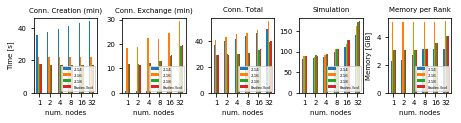

In [16]:
hpc_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_n1_s15.csv')
hpc_m['Case']   = ['8adec3cd']*len(hpc_m)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['num. nodes'] = hpc_versions['NUMBER_OF_NODES']
hpc_versions['Simulation'] = hpc_versions['T_sim']
hpc_versions_p = plot_compare(hpc_versions, 'benchmark_figures/hpc_different_versions.pdf',
                              values = ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Simulation', 'Memory per Rank'],
                              index='num. nodes', rot=0)
save_table_latex(hpc_versions_p.to_latex(), 'latex_tables/hpc_different_versions.txt')

hpc_versions_p